##### Universidade Federal de São Carlos - UFSCar <br>Centro de Ciências Exatas e Tecnólogicas - CCET

# Trabalho de Graduação A
### Uma abordagem estatística sobre a estimação de _redshifts_ de quasares usando dados do S-PLUS
#### Análise descritiva dos dados do S-PLUS

Discente: Gabriela Pereira Soares<br>Orientador: Rafael Izbicki<br>Co-orientadora: Lilianne Nakazono

Abril de 2022

In [1]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats
import flexcode
import warnings
from flexcode.regression_models import RandomForest
from flexcode.regression_models import XGBoost
from flexcode.regression_models import NN
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.patches as mpatches
%matplotlib inline

Vamos carregar o mesmo conjunto de dados utilizado na pesquisa de Raquel para que o experimento seja comparável.

In [2]:
caminho = "C:/Users/Gabriela/Documents/TG/Análises Preliminares/database/"

# Carregando os dados de treinamento
trainfold0 = pd.read_csv(caminho+"trainfold0.csv", low_memory=False)
trainfold1 = pd.read_csv(caminho+"trainfold1.csv", low_memory=False)
trainfold2 = pd.read_csv(caminho+"trainfold2.csv", low_memory=False)
trainfold3 = pd.read_csv(caminho+"trainfold3.csv", low_memory=False)
trainfold4 = pd.read_csv(caminho+"trainfold4.csv", low_memory=False)

# Carregando os dados de validação
validationfold0 = pd.read_csv(caminho+"validationfold0.csv", low_memory=False)
validationfold1 = pd.read_csv(caminho+"validationfold1.csv", low_memory=False)
validationfold2 = pd.read_csv(caminho+"validationfold2.csv", low_memory=False)
validationfold3 = pd.read_csv(caminho+"validationfold3.csv", low_memory=False)
validationfold4 = pd.read_csv(caminho+"validationfold4.csv", low_memory=False)

# Carregando a amostra de teste
test = pd.read_csv(caminho+"test.csv", low_memory=False)

In [3]:
print(len(trainfold0),len(validationfold0),len(test))

16413 4104 6840


In [4]:
# Concatenando os datasets para obter o conjunto completo
dados = pd.concat([trainfold0,validationfold0,test])

In [5]:
dados.head()

,index,Field,ID,RA_1,DEC_1,X,Y,ISOarea,MU_MAX,A,...,J0410_iso-r_iso,J0430_iso-r_iso,J0515_iso-r_iso,r_iso-J0660_iso,r_iso-J0861_iso,r_iso-W1_MAG,r_iso-W2_MAG,FUVmag-r_iso,NUVmag-r_iso,Zclass
0,35844,STRIPE82-0163,iDR3.STRIPE82-0163.035411,353.801826,-0.482775,8962.2810,6922.2110,12,17.508287,1.320163,...,0.592438,1.358313,0.111649,-0.061876,-0.692299,4.705591,5.889046,0.567219,-0.258181,2
1,25926,STRIPE82-0125,iDR3.STRIPE82-0125.048006,326.841560,-0.369219,9166.1550,7665.5225,4,17.009247,1.334710,...,-0.225453,1.010672,0.496397,-0.126772,0.390370,4.144383,4.467175,NaN,NaN,4
2,18869,STRIPE82-0060,iDR3.STRIPE82-0060.003444,41.635591,0.091411,2009.9844,1516.8861,35,16.349241,1.692433,...,0.373749,0.096077,0.125700,-0.032084,-0.011645,3.713305,4.999304,NaN,NaN,2
3,3047,STRIPE82-0011,iDR3.STRIPE82-0011.008800,6.670586,-1.163833,8223.1670,2464.2346,9,17.234804,1.535165,...,0.254142,0.419345,0.850948,-0.114995,0.314160,3.152518,5.045413,NaN,NaN,2
4,32829,STRIPE82-0152,iDR3.STRIPE82-0152.033297,345.323720,0.765429,8792.9930,5928.9526,9,17.711014,1.117999,...,1.047352,1.523887,0.219181,0.152403,0.417545,4.629427,5.581610,NaN,NaN,3


In [6]:
# Alterando a nomenclatura das colunas
def replace_all(dados, dic):
    cols = dados.columns.values
    for i, j in dic.items():
        cols = [w.replace(i, j) for w in cols]
    return cols

dic = {'F378':'J0378', 'F395':'J0395', 'F410':'J0410', 'F430':'J0430', 
       'F515':'J0515', 'F660':'J0660', 'F861':'J0861', 'R_iso':'r_iso',
       'U_iso':'u_iso','G_iso':'g_iso','I_iso':'i_iso','Z_iso':'z_iso',
       "U_aper":"u_aper","U_auto":"u_auto","U_petro":"u_petro","U_PStotal":"u_PStotal"}

dados.columns = replace_all(dados,dic)

In [7]:
dados.shape

(27357, 625)

No total, temos 27.357 linhas e 625 colunas. As linhas contemplam o dataset original já tratado, ou seja, considerando as observações com $0 < r\_iso < 22$ e $0 < z < 7$. As colunas também incluem variáveis de cor criadas e a classificação do _redshift_.

In [8]:
# Verificando o intervalo da banda r_iso e do redshift Z
pd.concat([dados['r_iso'].describe(),dados['Z'].describe()], axis=1)

,r_iso,Z
count,27335.000000,27357.000000
mean,20.718616,1.621008
std,0.922937,0.757056
min,15.399064,0.034357
25%,20.173191,1.058147
50%,20.889393,1.538000
75%,21.446664,2.090000
max,21.999947,6.999202


Vamos fazer uma análise descritiva das principais variáveis no banco de dados, que são as magnitudes do S-PLUS, WISE e GALEX, seus respectivos erros e o redshift Z. A principal abertura que iremos analisar é a abertura isofótica, por apresentar resultados melhores em pesquisas anteriores. Porém as outras aberturas também serão avaliadas ao longo do estudo.

In [9]:
apers = ["auto", "aper_3", "aper_6", "iso", "petro", "PStotal"] # aberturas
feat_broad = ['u', 'g', 'r', 'i', 'z'] # banda larga
feat_narrow = ['J0378', 'J0395', 'J0410', 'J0430', 'J0515', 'J0660', 'J0861'] # banda estreita

feat = feat_broad+feat_narrow
splus_aper = []
splus_iso = [item+"_iso" for item in feat]

for a in apers:
    splus_aper = splus_aper + [item+"_"+a for item in feat]

# Magnitudes
wise = ["W1_MAG", "W2_MAG"]
galex = ['FUVmag', 'NUVmag']

# Erros
error_splus = ["e_"+item for item in splus_aper]
error_iso = ["e_"+item for item in splus_iso]
error_wise = [item+"_ERR" for item in wise]
error_galex = ["e_"+item for item in galex]

In [10]:
cols=splus_iso+wise+galex
dados[cols].describe()

,u_iso,g_iso,r_iso,i_iso,z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,J0660_iso,J0861_iso,W1_MAG,W2_MAG,FUVmag,NUVmag
count,26213.000000,27347.000000,27335.000000,27355.000000,27350.000000,26075.000000,25322.000000,25913.000000,26349.000000,27002.000000,27293.000000,27138.000000,27072.000000,26955.000000,3618.000000,9705.000000
mean,21.718498,21.094590,20.718616,20.504942,20.350146,21.472781,21.344388,21.337572,21.263177,21.043031,20.767463,20.496598,16.543784,15.466508,21.381903,21.265999
std,1.298349,1.005644,0.922937,0.934624,0.956597,1.281213,1.278683,1.249019,1.230193,1.138898,1.019406,1.066663,1.050298,1.089562,0.894702,0.947314
min,15.693669,15.546192,15.399064,15.110929,14.914334,15.586912,15.553884,15.505044,15.484595,15.560777,15.433805,15.018042,10.570083,9.603073,16.002700,16.042100
25%,20.925241,20.489469,20.173191,19.948298,19.786834,20.698516,20.569222,20.588250,20.526245,20.368664,20.160458,19.864320,15.920853,14.827140,20.908325,20.704900
50%,21.732521,21.236340,20.889393,20.642134,20.462140,21.480019,21.308716,21.333685,21.271751,21.104723,20.888712,20.561314,16.580088,15.497491,21.522550,21.386500
75%,22.451235,21.807513,21.446664,21.192151,21.005415,22.196167,22.041687,22.025726,21.954077,21.726707,21.474611,21.148804,17.196137,16.115449,22.026700,21.965800
max,33.947880,33.175200,21.999947,27.712261,26.905193,34.631280,29.321917,33.050335,34.014053,35.604820,35.095410,29.125994,24.925806,26.437078,23.128900,23.390800


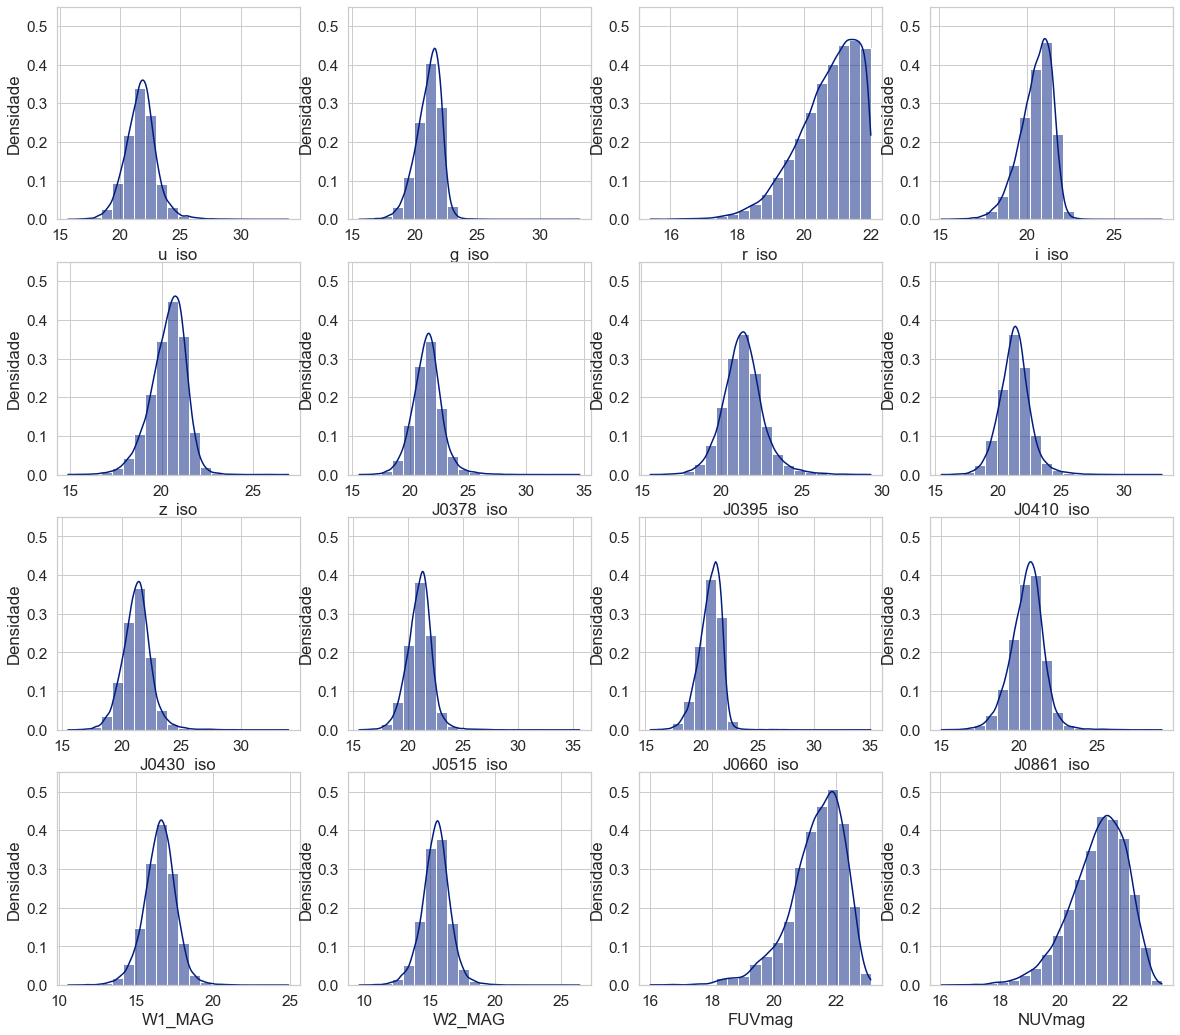

In [15]:
# Histogramas
sns.set(context="notebook", style="whitegrid", palette="dark",font_scale=1.4)

fig, axs = plt.subplots(4, 4, figsize=(20, 18))
dic = {0:axs[0,0], 1:axs[0,1], 2:axs[0,2], 3:axs[0,3],
       4:axs[1,0], 5:axs[1,1], 6:axs[1,2], 7:axs[1,3],
       8:axs[2,0], 9:axs[2,1],10:axs[2,2],11:axs[2,3],
      12:axs[3,0],13:axs[3,1],14:axs[3,2],15:axs[3,3]}

for i in range(16):
    sns.histplot(data=dados[cols[i]], bins=20, kde=True, stat='density', ax=dic[i]).set(ylim=(0, 0.55),ylabel="Densidade")
plt.show()

Vemos que a maioria das magnitudes apresentam distribuições simétricas, com mais _outliers_ à direita, com exceção da FUVmag, NUVmag e a banda R, que apresentam grande assimetria à esquerda. Vale lembrar que o formato da distribuição da banda R se deve possívelmente ao fato de termos "cortado" os valores acima de 22.

In [12]:
errs = error_iso+error_wise+error_galex
dados[errs].describe().round(2)

,e_u_iso,e_g_iso,e_r_iso,e_i_iso,e_z_iso,e_J0378_iso,e_J0395_iso,e_J0410_iso,e_J0430_iso,e_J0515_iso,e_J0660_iso,e_J0861_iso,W1_MAG_ERR,W2_MAG_ERR,e_FUVmag,e_NUVmag
count,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27357.00,27255.00,27138.00,3618.00,9705.00
mean,2.09,0.36,0.11,0.11,0.19,4.42,2.58,2.65,4.91,4.00,2.40,0.59,0.13,0.27,0.31,0.26
std,83.54,37.20,0.65,0.51,0.49,359.51,9.83,69.71,390.35,497.90,351.18,6.41,1.58,15.33,0.11,0.12
min,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,-1.00,-1.00,0.02,0.01
25%,0.13,0.06,0.05,0.06,0.10,0.16,0.24,0.20,0.18,0.14,0.06,0.13,0.04,0.05,0.23,0.16
50%,0.23,0.10,0.08,0.10,0.15,0.29,0.42,0.35,0.31,0.23,0.10,0.21,0.07,0.10,0.32,0.25
75%,0.43,0.15,0.12,0.14,0.22,0.55,0.86,0.66,0.55,0.37,0.15,0.32,0.13,0.18,0.40,0.35
max,13716.10,6151.83,23.76,76.97,29.66,58164.53,886.58,9400.49,57049.36,82242.67,58072.38,737.46,171.72,2521.75,0.54,0.50


In [13]:
# Quantil 95%
dados[errs].quantile(q=0.9).round(2)

e_u_iso        1.12
e_g_iso        0.21
e_r_iso        0.15
e_i_iso        0.18
e_z_iso        0.30
e_J0378_iso    1.44
e_J0395_iso    4.42
e_J0410_iso    1.91
e_J0430_iso    1.26
e_J0515_iso    0.63
e_J0660_iso    0.20
e_J0861_iso    0.51
W1_MAG_ERR     0.22
W2_MAG_ERR     0.31
e_FUVmag       0.46
e_NUVmag       0.42
Name: 0.9, dtype: float64

<AxesSubplot:xlabel='J0861_iso', ylabel='e_J0861_iso'>

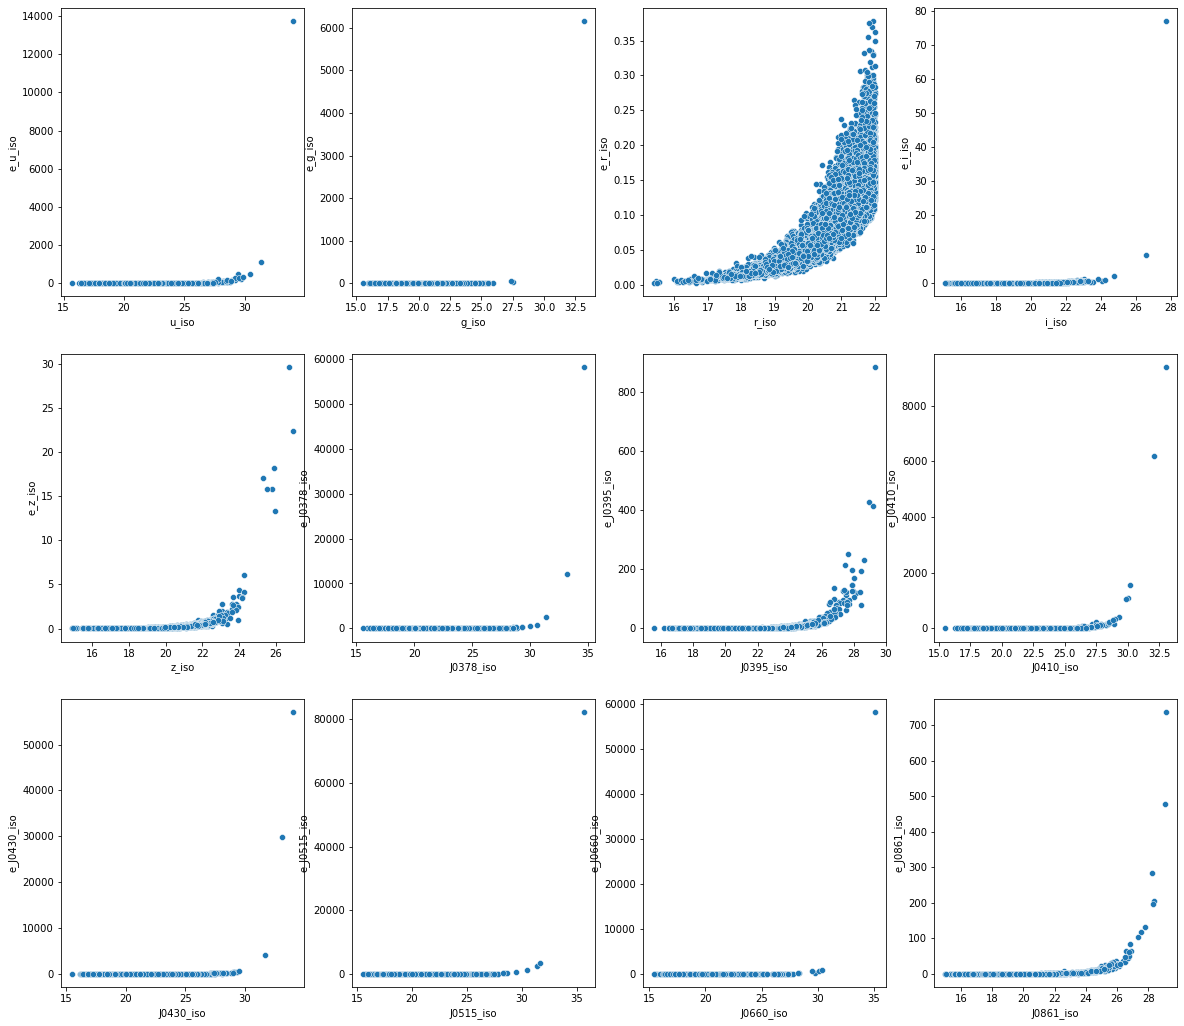

In [20]:
# Relação das magnitudes do S-PLUS com seus respectivos erros
fig, axs = plt.subplots(3, 4, figsize=(20, 18))
sns.scatterplot(y=dados['e_u_iso'],x=dados['u_iso'], ax=axs[0,0])
sns.scatterplot(y=dados['e_g_iso'],x=dados['g_iso'], ax=axs[0,1])
sns.scatterplot(y=dados['e_r_iso'],x=dados['r_iso'], ax=axs[0,2])
sns.scatterplot(y=dados['e_i_iso'],x=dados['i_iso'], ax=axs[0,3])
sns.scatterplot(y=dados['e_z_iso'],x=dados['z_iso'], ax=axs[1,0])
sns.scatterplot(y=dados['e_J0378_iso'],x=dados['J0378_iso'], ax=axs[1,1])
sns.scatterplot(y=dados['e_J0395_iso'],x=dados['J0395_iso'], ax=axs[1,2])
sns.scatterplot(y=dados['e_J0410_iso'],x=dados['J0410_iso'], ax=axs[1,3])
sns.scatterplot(y=dados['e_J0430_iso'],x=dados['J0430_iso'], ax=axs[2,0])
sns.scatterplot(y=dados['e_J0515_iso'],x=dados['J0515_iso'], ax=axs[2,1])
sns.scatterplot(y=dados['e_J0660_iso'],x=dados['J0660_iso'], ax=axs[2,2])
sns.scatterplot(y=dados['e_J0861_iso'],x=dados['J0861_iso'], ax=axs[2,3])

Vemos que os erros têm valores próximos a 0 até a magnitude 22~30 e depois disso o erro aumenta exponencialmente.

In [94]:
# Um caso do erro com valor extremo
# Nota-se que a banda U têm alta magnitude
dados.loc[dados["e_U_iso"] > 13716, cols]

,U_iso,G_iso,R_iso,I_iso,Z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,J0660_iso,J0861_iso,W1_MAG,W2_MAG,FUVmag,NUVmag
5175,33.94788,21.342657,21.130348,21.314491,20.514355,22.681349,NaN,21.971113,21.900698,21.245708,20.98304,21.069418,17.816738,NaN,NaN,NaN


Vamos ver a distribuição do _redshift_ como um todo. Aqui, mostramos também que a proporção de valores do _redshift_ é mantida para cada conjunto de dados.

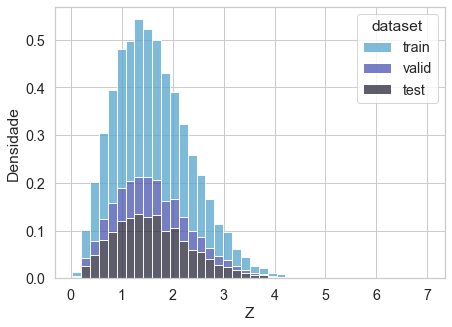

In [32]:
dados_z = pd.DataFrame({'Z':dados["Z"].values, 'dataset':["train"]*16413+["valid"]*4104+["test"]*6840})
fig = plt.figure(figsize=(7,5))
sns.set(context="notebook", style="whitegrid", palette="icefire",font_scale=1.3)
sns.histplot(dados_z,x="Z", hue="dataset",multiple="stack", bins=40, stat="density").set(ylabel="Densidade")
plt.show()

Agora vamos analisar o _redshift_ e ver também como os valores _missing_ nas magnitudes impactam em sua distribuição.

C:\Users\Gabriela\AppData\Local\Temp/ipykernel_4212/2089091199.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([p1,p2],     # The line objects


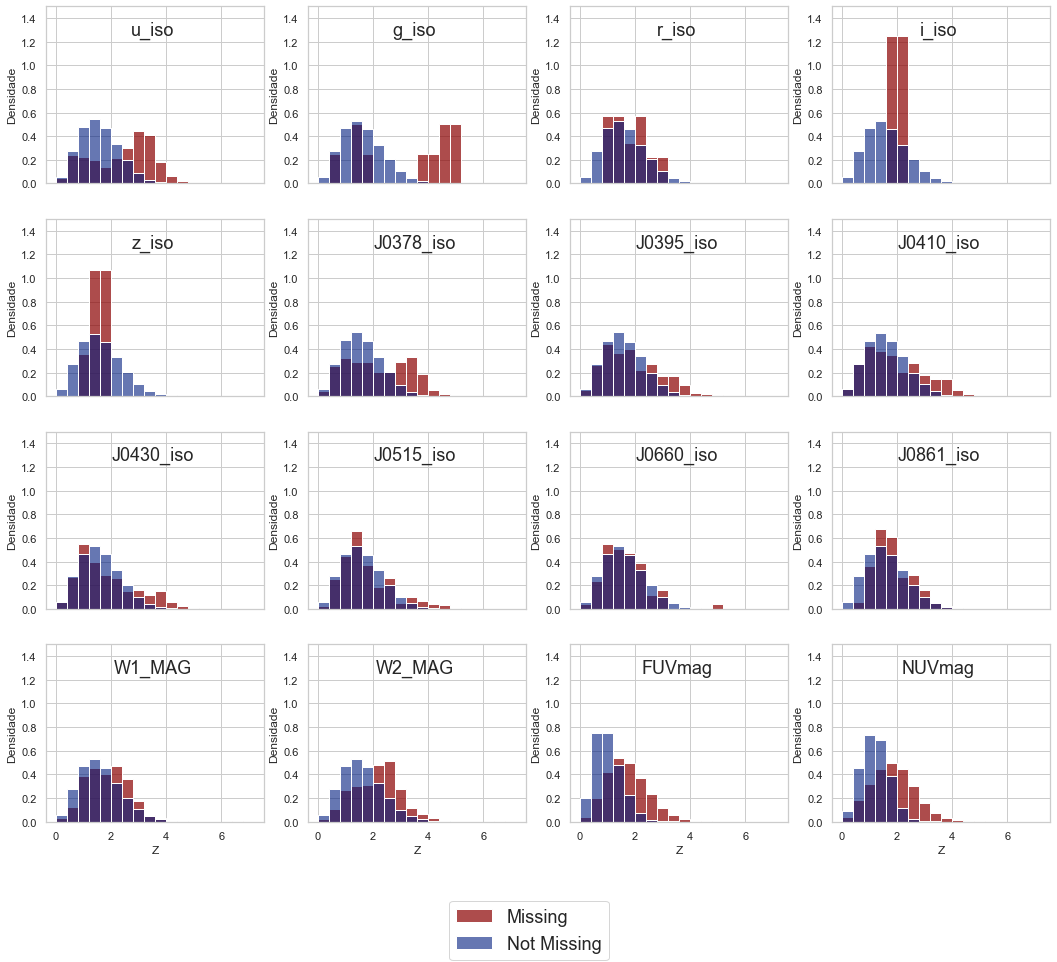

In [35]:
# Redshift vs missing
sns.set(context="notebook", style="whitegrid", palette="dark", font_scale=1)

fig, axs = plt.subplots(4, 4, figsize=(18, 15), sharex = True)
dic = {0:axs[0,0], 1:axs[0,1], 2:axs[0,2], 3:axs[0,3],
       4:axs[1,0], 5:axs[1,1], 6:axs[1,2], 7:axs[1,3],
       8:axs[2,0], 9:axs[2,1],10:axs[2,2],11:axs[2,3],
      12:axs[3,0],13:axs[3,1],14:axs[3,2],15:axs[3,3]}
mis = dados[cols].isna()

for i in range(16):
    p1=sns.histplot(data=dados.loc[mis[cols[i]] == True]["Z"],color="darkred",
                    binwidth=0.4, bins=20, stat='density', ax=dic[i], alpha=0.7, 
                    binrange=[0,7]).set(ylim=(0, 1.5), ylabel="Densidade")
    p2=sns.histplot(data=dados.loc[mis[cols[i]] == False]["Z"],binwidth=0.4, binrange=[0,7],
                    stat='density', ax=dic[i], alpha=0.6).set(ylim=(0, 1.5))
    dic[i].text(3.5,1.3, cols[i], ha="center", va="center", fontsize=18)
    
fig.legend([p1,p2],     # The line objects
           labels=["Missing","Not Missing"],   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           prop={'size': 18})    
# red_patch = mpatches.Patch(color='darkred', label='Missing')
# blue_patch = mpatches.Patch(color='darkblue', label='Not Missing')
plt.show()

In [26]:
fig.get_figure().savefig("dens_NA.png",  bbox_inches='tight') 

Aqui, vemos que a distribuição do _redshift_ como um todo tende a se deslocar para a direita quando há valores faltantes em alguma banda, indicando que valores _missing_ nas magnitudes influenciam à maiores valores de _redshift_, principalmente em relação às bandas do GALEX e as bandas U_iso e G_iso.

Podemos ver também como as observações _missing_ se correlacionam.

In [51]:
missing_values = (dados[cols].isnull().sum() / len(dados[cols]))*100
#missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True, ascending=False)
missing_values = missing_values.to_frame()
missing_values.columns = ['% NA']
missing_values['Contagem'] = dados[cols].isnull().sum()
missing_values.index.names = ['Variável']
missing_values['Variável'] = missing_values.index
missing_values

,% NA,Contagem,Variável
Variável,,,
FUVmag,86.774866,23739,FUVmag
NUVmag,64.524619,17652,NUVmag
J0395_iso,7.438681,2035,J0395_iso
J0410_iso,5.278357,1444,J0410_iso
J0378_iso,4.686186,1282,J0378_iso
u_iso,4.181745,1144,u_iso
J0430_iso,3.684615,1008,J0430_iso
W2_MAG,1.469459,402,W2_MAG
J0515_iso,1.297657,355,J0515_iso


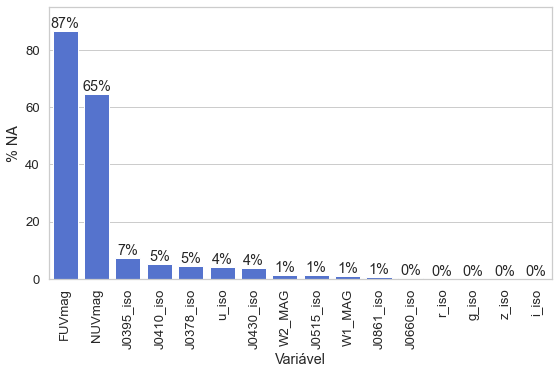

In [59]:
fig = plt.figure(figsize=(9,5))
sns.set(context="notebook", style="whitegrid", palette="dark",font_scale=1.2)
ax = sns.barplot(x = 'Variável', y = '% NA', data=missing_values, color='royalblue')
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.xticks(rotation = 90)
plt.ylim(0,95)
plt.show()

Vemos as magnitudes do GALEX com alta taxa de valores missing.

In [23]:
cols2=error_splus+error_wise+error_galex+splus_aper+galex+wise
df_na = dados[cols2].isna().sum().to_frame("Contagem")
df_na["%"] = df_na["Contagem"]/dados[cols2].shape[0] 
df_na.loc[df_na["%"]!=0].sort_values(by="%", ascending=False)

,Contagem,%
e_FUVmag,23739,0.867749
FUVmag,23739,0.867749
e_NUVmag,17652,0.645246
NUVmag,17652,0.645246
J0395_iso,2035,0.074387
J0410_iso,1444,0.052784
J0378_iso,1282,0.046862
U_iso,1144,0.041817
J0430_iso,1008,0.036846
W2_MAG,402,0.014695


<AxesSubplot:>

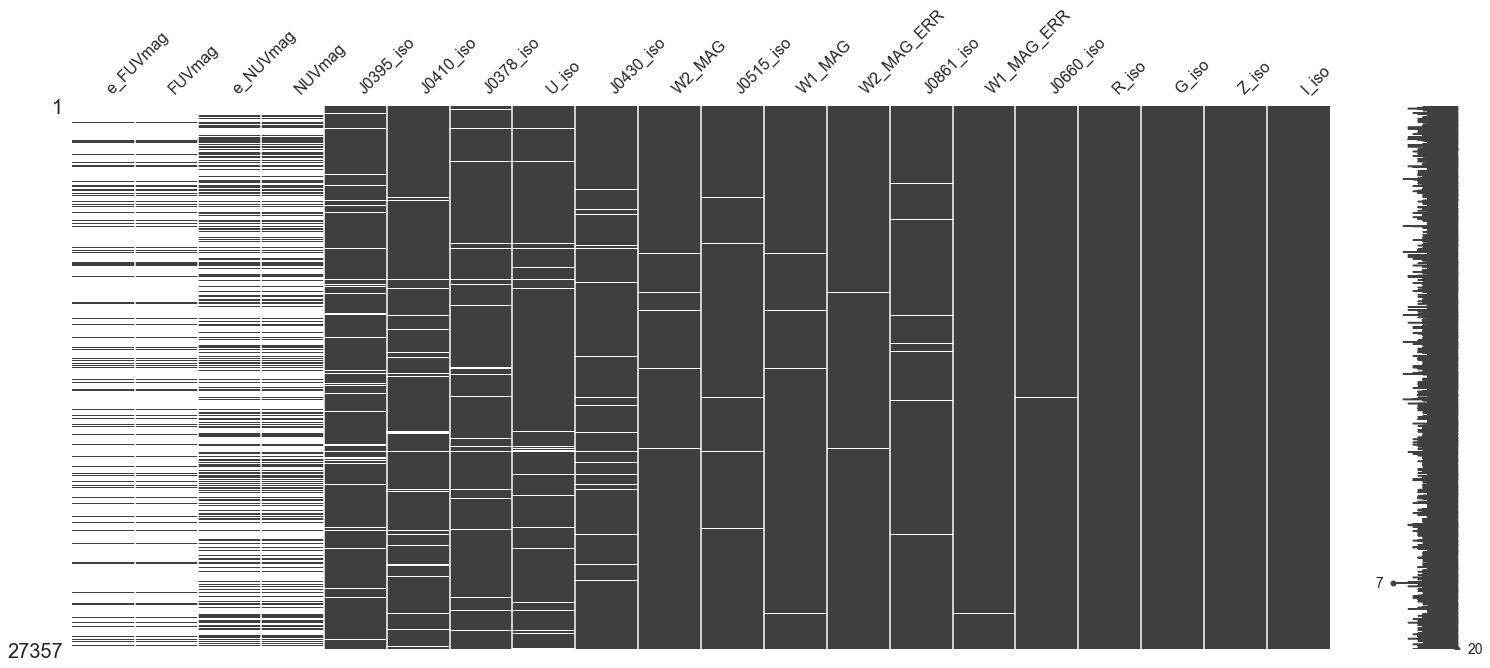

In [24]:
import missingno as msno
msno.matrix(dados[df_na.loc[df_na["%"]!=0].sort_values(by="%", ascending=False).index])

Percebemos uma relação entre os valores _missing_ das bandas do GALEX e seus respectivos erros, ou seja, quando há dados faltantes nas magnitudes, também haverá nos erros. Os demais não parecem ter relação.

**Lembrando que os dados faltantes serão substituíduos pelo valor 99, dado que eles possivelmente trazem informação a respeito do _redshift_, e também a falta de informação tem uma justificativo física-astronômica**

<AxesSubplot:ylabel='Density'>

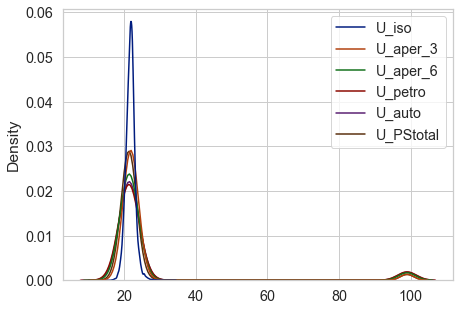

In [37]:
fig = plt.figure(figsize=(7,5))
sns.set(context="notebook", style="whitegrid", palette="dark",font_scale=1.3)
sns.kdeplot(data=dados[["u_iso","u_aper_3","u_aper_6","u_petro","u_auto","u_PStotal"]])

(10.0, 40.0)

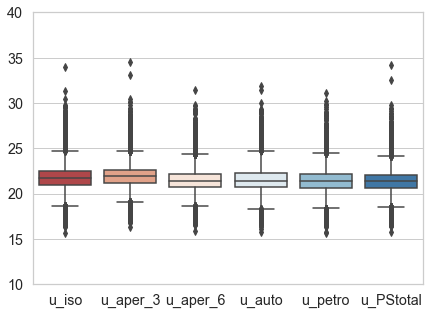

In [84]:
fig = plt.figure(figsize=(7,5))
sns.set(context="notebook", style="whitegrid", palette="RdBu",font_scale=1.3)
sns.boxplot(data=dados[["u_iso","u_aper_3","u_aper_6","u_auto","u_petro","u_PStotal"]], orient="v")
plt.ylim(10, 40)

Aparentemente, a distribuição dos dados considerando a banda U e diferentes aberturas parece ser a mesma. Assim, faz-se desnecessário analisar todas as aberturas. Consideraremos isso como verdade para as demais bandas. <br> **OBS.:** Possivelmente isso deve ter algum sentido de imageamento, dado que é a mesma banda e estamos apenas mudando a abertura.

<AxesSubplot:>

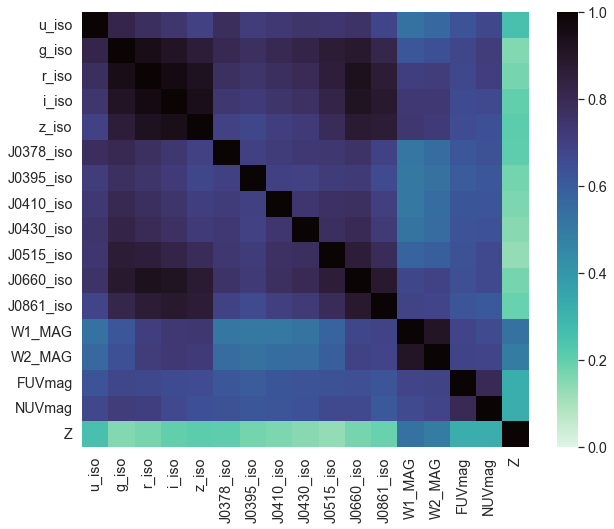

In [89]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dados[cols+["Z"]].corr(),cmap='mako_r', vmin=0, vmax=1)

Não vemos nenhuma correlação forte das magnitudes com o _redshift_, porém os filtros entre si possuem alta relação em cada grupo.